In [151]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

SIR com fator de normalização.
$$\ \dot{S} = \frac{- \beta I S}{N}$$
$$\ \dot{I} = \frac{\beta I S}{N} - \gamma I$$
$$\ \dot{R} = - \gamma I S$$
com $$N = S + I + R$$
obs.: variável independente ocultada para simplificar a notação

(é um sistema de EDOs...)

## Redes neurais

### Feedforward

In [152]:
np.random.seed(6661)

In [153]:
# 0 para 160
t = np.linspace(0, 160, 161)

beta = 0.2  # Taxa de infecção
gamma = 0.1  # Taxa de recuperação

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)


def sir_deriv(s_i_r, t0, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    N = S + I + R
    dS = (-beta * S * I) / N
    dI = ((beta * S * I) / N) - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

# random int values between 1000 and 2000
s = np.random.randint(1000, 2000, size=100)
# random int values between 200 and 300
i = np.random.randint(100, 200, size=100)
# random int values between 0 and 100
r = np.random.randint(0, 50, size=100)
x0_o = np.array([s, i, r])

In [154]:
# normalizando SIR de 0 a 1
#s = (s - s.min()) / (s.max() - s.min())
#i = (i - i.min()) / (i.max() - i.min())
#r = (r - r.min()) / (r.max() - r.min())
s = s / 1000
i = i / 1000
r = r / 1000

x0 = np.array([s, i, r]).T
print(x0.shape)

(100, 3)


In [155]:
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])
print(x_t.shape)
x_t[1][0]

(100, 161, 3)


array([1.015, 0.14 , 0.047])

In [156]:
for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
nn_input.shape

(16000, 3)

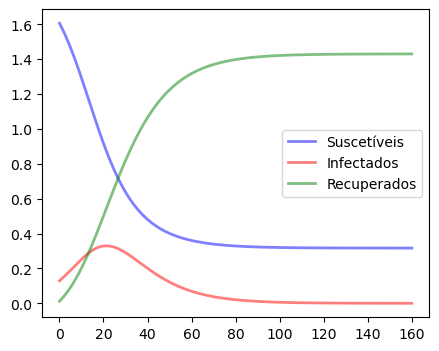

In [157]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x_t[0, :, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x_t[0, :, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x_t[0, :, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

Até aqui tudo certo. Esta é mesmo a "cara" do SIR.

In [158]:
print(nn_input.shape)
print(nn_output.shape)

(16000, 3)
(16000, 3)


In [159]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='linear'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')

In [160]:
History = net.fit(nn_input, nn_output, epochs=10, verbose=1)

Epoch 1/10
500/500 [==============================] - 1s 770us/step - loss: 0.0450
Epoch 2/10
500/500 [==============================] - 0s 754us/step - loss: 0.0013
Epoch 3/10
500/500 [==============================] - 0s 693us/step - loss: 5.8365e-04
Epoch 4/10
500/500 [==============================] - 0s 707us/step - loss: 2.8336e-04
Epoch 5/10
500/500 [==============================] - 0s 731us/step - loss: 1.4559e-04
Epoch 6/10
500/500 [==============================] - 0s 693us/step - loss: 1.0392e-04
Epoch 7/10
500/500 [==============================] - 0s 713us/step - loss: 7.9719e-05
Epoch 8/10
500/500 [==============================] - 0s 699us/step - loss: 5.3481e-05
Epoch 9/10
500/500 [==============================] - 0s 713us/step - loss: 2.7751e-05
Epoch 10/10
500/500 [==============================] - 0s 717us/step - loss: 6.0442e-06


In [161]:
np.random.seed(6661)
ynn = np.zeros((1, len(t), 3))
ynn[0, 0, :] = (np.random.randint(1000, 2000), np.random.randint(100, 200), np.random.randint(0, 50))
# normalizando SIR de 0 a 1
ynn[0, 0, :] = (ynn[0, 0, :] - ynn[0, 0, :].min()) / (ynn[0, 0, :].max() - ynn[0, 0, :].min())
print(ynn[0, 0, :])
for jj, tval in enumerate(t[:-1]):
    ynn[0, jj + 1, :] = net.predict(ynn[:, jj, :], verbose = 1)

[1.         0.05930599 0.        ]
1/1 [==============================] - 0s 13ms/step


In [162]:
y0 = ynn[0, 0, :]
y_t = integrate.odeint(sir_deriv, y0, t)

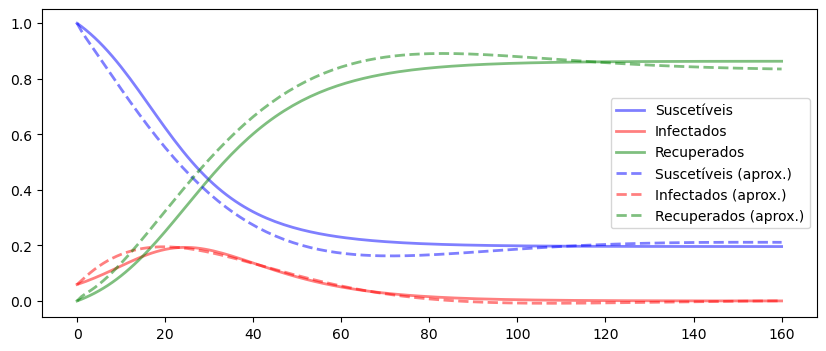

In [163]:
# plot y_t
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, y_t[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, y_t[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, y_t[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
# plot predição
ax.plot(t, ynn[0, :, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, ynn[0, :, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, ynn[0, :, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()
plt.show()

Um resultado similar ao do experimento com o atrator de Lorenz: uma boa aproximação do comportamento, apesar de não muito precisa. Para a baixíssima quantidade de *epochs* e a simplicidade da rede de um modo geral, trata-se de um resultado satisfatório.

Antes deste "sucesso", foram testados: SIR não normalizado, SIR normalizado sem normalização nas entradas, SIR normalizado com normalização nas entradas. Em todos os casos, foi usada a sequência de funções de ativação: ``sigmoid``, ``relu`` e ``linear``, todas sem sucesso

### LSTM

TODO

## Métodos numéricos

### SINDy

In [164]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
print(y0)
# Integrate the SIR equations over the time grid, t.
x = integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = x.T
S, I, R

(999, 1, 0)


(array([999.        , 998.78852485, 998.5547709 , 998.29640937,
        998.01087209, 997.69532779, 997.3466563 , 996.96142032,
        996.53583508, 996.06573476, 995.54653691, 994.97320367,
        994.34020005, 993.64144932, 992.87028523, 992.01940138,
        991.08079756, 990.04572343, 988.90461975, 987.64705758,
        986.26167619, 984.73612027, 983.0569776 , 981.20971853,
        979.17863889, 976.94680822, 974.49602596, 971.80678857,
        968.85827062, 965.6283242 , 962.09350118, 958.22910306,
        954.00926412, 949.40707412, 944.39474629, 938.94383706,
        933.0255237 , 926.61094483, 919.67160815, 912.17986829,
        904.10947366, 895.43618047, 886.13842731, 876.1980576 ,
        865.60107434, 854.33840784, 842.40666714, 829.80884389,
        816.55493828, 802.66246618, 788.15681168, 773.07139528,
        757.44762515, 741.3346135 , 724.78865514, 707.87246206,
        690.65417774, 673.20620643, 655.60389178, 637.92410381,
        620.24378958, 602.6385473 , 585.

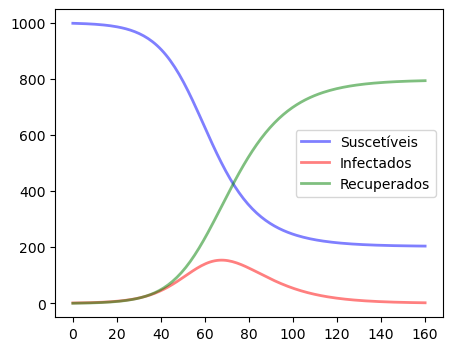

In [165]:
# plot SIR
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
plt.legend()
plt.show()

In [166]:
## Compute Derivative
dx = np.zeros_like(x)
for j in range(len(t)):
    dx[j,:] = deriv(x[j,:],0,N,beta,gamma)

In [167]:
import pysindy as ps

In [168]:
model = ps.SINDy(feature_names=['S','I','R'])
model.fit(x, t=t, x_dot=dx)
# plot model
model.print()
res = model.simulate(x[0], t)

(S)' = 0.000
(I)' = 0.000
(R)' = 0.000


c:\Users\Daniel\miniconda3\lib\site-packages\pysindy\optimizers\stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


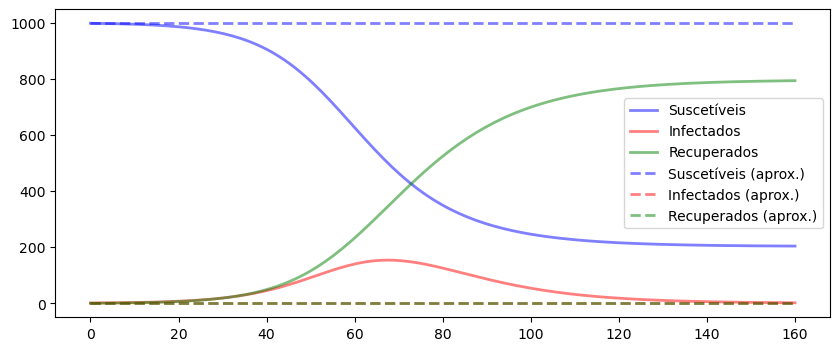

In [169]:
# plot res
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x[:, 0], 'b', alpha=0.5, lw=2, label='Suscetíveis')
ax.plot(t, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, x[:, 2], 'g', alpha=0.5, lw=2, label='Recuperados')
# plot predição
ax.plot(t, res[:, 0], 'b--', alpha=0.5, lw=2, label='Suscetíveis (aprox.)')
ax.plot(t, res[:, 1], 'r--', alpha=0.5, lw=2, label='Infectados (aprox.)')
ax.plot(t, res[:, 2], 'g--', alpha=0.5, lw=2, label='Recuperados (aprox.)')
plt.legend()